In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import neurkal

import itertools
import numpy as np
from matplotlib import pyplot as plt
from scipy.misc import derivative
import seaborn as sns

In [6]:
## Plot style setup
sns.set_style("whitegrid")
palette = itertools.cycle(sns.color_palette())

In [7]:
def gaussian_filter(p, K_w, delta):
    def filt(i, k):
        return K_w * np.exp((np.cos(2*np.pi*(i - k)/p) - 1) / delta**2)
    return filt

In [30]:
def gen_input_act(a, b=2, c=1, d=0.01):
    def input_act(x, x_i):
        return a * (np.exp(b * (np.cos(np.deg2rad(x - x_i)) - c)) + d)
    def input_act_d(x, x_i):
        return -a * b * np.sin(np.deg2rad(x - x_i)) * np.exp(b * (np.cos(np.deg2rad(x - x_i)) - c))
    return input_act, input_act_d

In [31]:
input_act, input_act_d = gen_input_act(3, 2, 1, 0.01)

In [32]:
space = [-180, 180]  # range of preferred values

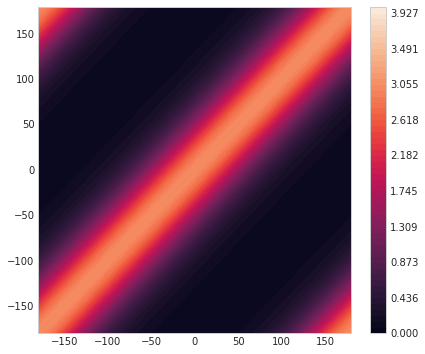

In [33]:
## Visualize activation function for sensory input layer
act = np.vectorize(input_act)
x = np.arange(*space, 1)
z = act(*np.meshgrid(x, x))
levels = np.linspace(np.floor(np.min(z)), np.ceil(np.max(z)), 56)

fig, ax = plt.subplots(figsize=(7, 6))
act_cf = ax.contourf(x, x, z, levels=levels)
plt.colorbar(act_cf)
plt.show()

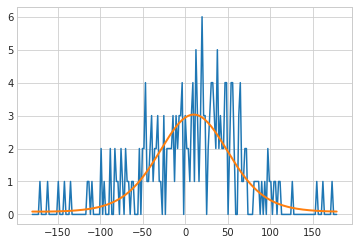

In [34]:
## Sensory input layer example activation
sensory_code = neurkal.PopCode(n=200, space=space, act_func=input_act, dist=np.random.poisson)
activity = sensory_code(10)
plt.plot(sensory_code.prefs, activity)
plt.plot(sensory_code.prefs, sensory_code.mean_activity, lw=2)
plt.show()

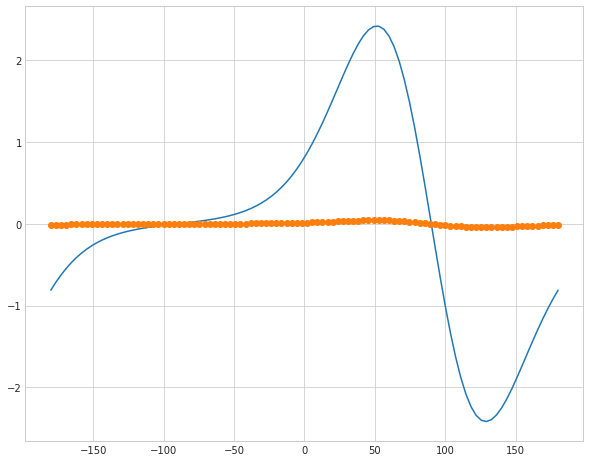

In [51]:
r = np.linspace(*space, 100)
pref = 90
fig, ax = plt.subplots(figsize=(10, 8))

actual = [input_act_d(x_, pref) for x_ in r]
num = [derivative(lambda x_: input_act(x_, pref), x_) for x_ in r]
ax.plot(r, actual, '-')
ax.plot(r, num, 'o')
plt.show()

array([-180.,  -90.,    0.,   90.,  180.])

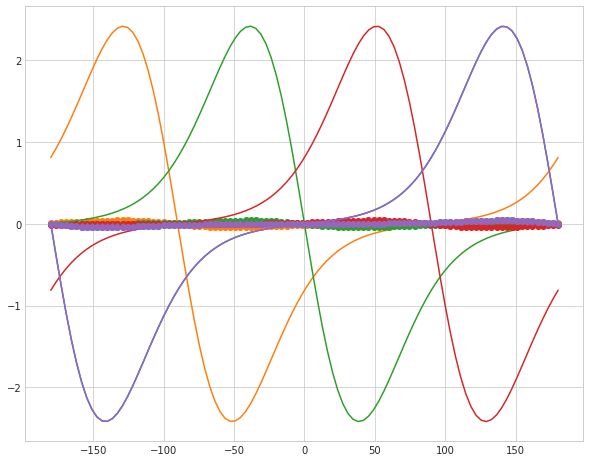

In [46]:
## Testing accuracy of numerical derivation of tuning curve with scipy.misc.derivative
r = np.linspace(*space, 100)
prefs = np.linspace(*space, 5)
fig, ax = plt.subplots(figsize=(10, 8))
for p in prefs:
    color = next(palette)
    f_ = lambda x_: input_act(x_, p)
    d_f_0 = np.array([input_act_d(x_, p) for x_ in r])
    d_f_1 = np.array([derivative(f_, x_, dx=1e-3) for x_ in r])
    d_f_2 = np.array([derivative(f_, x_, dx=5e1) for x_ in r])
    d_f_3 = np.array([derivative(f_, x_, dx=1e2) for x_ in r])
    ax.plot(r, d_f_0, '-', color=color)
    ax.plot(r, d_f_1, 'o', color=color)
    ax.plot(r, d_f_2, '.', color=color)
    ax.plot(r, d_f_3, ',', color=color)
    

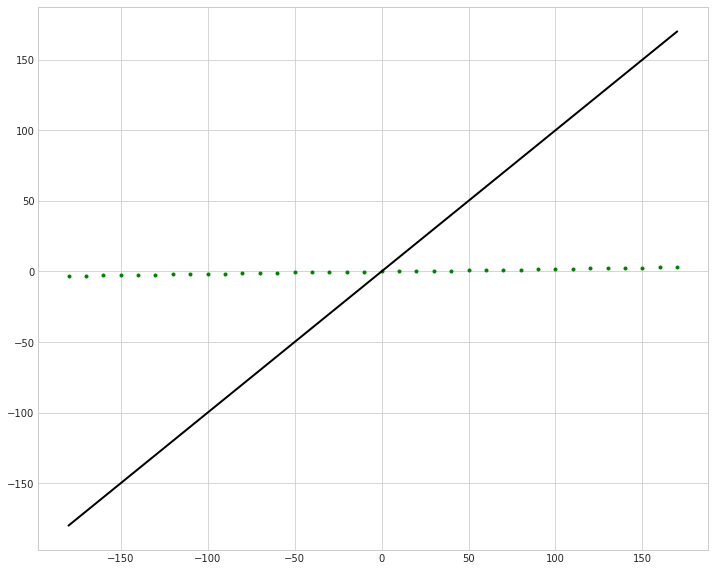

In [16]:
## Example evolution of noisy activity in recurrent network
# parameters
x = 2  # actual sensory input
p = 100  # number of units in network
delta = 0.718  # controls width of Gaussian filter giving recurrent weights
K_w = 1  # gain of recurrent connections
S = 0  # divisive normalization constant
mu = 0.002  # divisive normalization weight
steps = 200

filt = gaussian_filter(p, K_w, delta)

xs = np.arange(*space, 10)
x_est = []
for x in xs:
    recurrent_net = neurkal.RecurrentPopCode(weight_func=filt, S=S, mu=mu, n=p, space=space,
                                             act_func=input_act, dist=np.random.poisson)
    recurrent_net(x)  # initialize by (noisy) sampling
    prefs = recurrent_net.prefs
    cr_bound2 = recurrent_net.cr_bound
    for i in range(steps):
        recurrent_net.step()
    x_est.append(recurrent_net.readout())

x_est = np.array(x_est).T
fig, ax = plt.subplots(figsize=(12, 10))
ax.plot(xs, x_est, 'g.')
ax.plot(xs, xs, 'k-', lw=2)
plt.show()

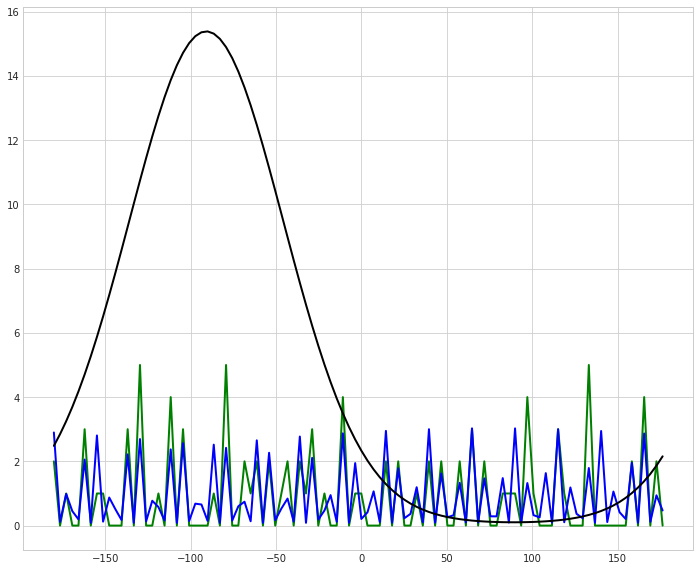

In [168]:
## Example evolution of noisy activity in recurrent network
def gaussian_filter(p, K_w, delta):
    def filt(i, k):
        return K_w * np.exp((np.cos(2*np.pi*(i - k)/p) - 1) / delta**2)
    return filt

# parameters
x = 2  # actual sensory input
space = [-180, 180]  # range of preferred values (deg)
p = 100  # number of units in network
delta = 0.718  # controls width of Gaussian filter giving recurrent weights
K_w = 1  # gain of recurrent connections
S = 0  # divisive normalization constant
mu = 0.002  # divisive normalization weight
steps = 200

filt = gaussian_filter(p, K_w, delta)

recurrent_net = neurkal.RecurrentPopCode(weight_func=filt, S=S, mu=mu, n=p, space=space,
                                         act_func=input_act, dist=np.random.poisson)
recurrent_net(x)  # initialize by (noisy) sampling
prefs = recurrent_net.prefs
cr_bound2 = recurrent_net.cr_bound

fs = recurrent_net.mean_activity
fig, ax = plt.subplots(figsize=(12, 10))
ax.plot(prefs, recurrent_net.activity, 'g', lw=2)
ax.plot(prefs, recurrent_net.mean_activity, 'b', lw=2)
for i in range(steps):
    recurrent_net.step()
ax.plot(prefs, recurrent_net.activity, 'k', lw=2)
plt.show()

In [10]:
# analytical Cramer-Rao bounds (vs. numerical method used in PopCode)
dx_f = np.array([input_act_d(x, x_i) for x_i in recurrent_net.prefs[0]])
cr_bound = 1 / np.matmul(np.matmul(dx_f, np.diag(fs)), dx_f.T)

In [11]:
cr_bound

0.0035904206216371922

In [15]:
# analyse variance of resulting estimates
trials = 1000
steps = 50

estimates = []

for t in range(trials):
    recurrent_net = neurkal.RecurrentPopCode(weight_func=filt, S=S, mu=mu, shape=p, 
                                             act_func=input_act, dist=np.random.poisson)
    recurrent_net(x)
    for i in range(steps):
        recurrent_net.step()
    estimates.append(recurrent_net.prefs[0][np.argmax(recurrent_net.activity)])
estimates = np.array(estimates)
var = np.sum((estimates - x) ** 2) / (trials - 1)
cr_bound = recurrent_net.cr_bound

In [16]:
# TODO: variance in estimates versus average firing rates and other parameters

In [37]:
# example basis network, for experiments
M = [[1, 0.5],
     [0, 0.9]]
B = [[0], 
     [1]]
sensory_codes = [neurkal.PopCode(shape=7, act_func=input_act, dist=np.random.poisson),
                neurkal.PopCode(shape=7, act_func=input_act, dist=np.random.poisson)]
motor_codes = [neurkal.PopCode(shape=7, act_func=input_act, dist=lambda x: x)]
basis = neurkal.KalmanBasisNetwork(sensory_codes, motor_codes, M=M, B=B)